<a href="https://colab.research.google.com/github/jadgle/GradientNN_MPC/blob/main/CuckerSmale_SDRE_MPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cucker Smale Model**

In this script we use the dataset generated in matlab to train a Neural Network predicting the V's (and their gradient w.r.t. the states).

In [1]:
%tensorflow_version 2.x
import sklearn
import time
import io

import pandas                as pd
import matplotlib.pyplot     as plt

from sklearn.neural_network  import MLPRegressor
from sklearn.metrics         import r2_score
from sklearn.model_selection import train_test_split
from google.colab            import files
from tensorflow              import keras
from tensorflow.keras        import layers

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Setting the seed value for reproducibility

In [2]:
# Seed value
seed_value = 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


Run the following codeblock and select the dataset we've just built in Matlab, saved as "data.csv".
The dataset will be stored in a Pandas DataFrame structure.

In [3]:
uploaded = files.upload()

Saving data.csv to data.csv


Data preprocessing

In [4]:
data = pd.read_csv(io.BytesIO(uploaded['data.csv']),header=None)
Na = 100
x = data.iloc[:,:2*Na]
dV = data.iloc[:,2*Na:4*Na+1]
u  = data.iloc[:,4*Na+1:]
x_train, x_test, y_train, y_test =  train_test_split(x, dV, test_size=0.2,random_state=seed_value)

V_train = y_train.iloc[:,0]
V_test  = y_test.iloc[:,0]

# Model with Custom Loss Function



We design a Neural Network with a custom loss function including the gradient. This should make the training of our NN more efficient. The custom loss reads

$$loss = \mu_V \Bigg[ \sum_{i=1}^{n}\frac{(V_i^{true}-V_i^{pred})^2}{n} \Bigg]+ \mu_{dV} \Bigg[ \sum_{i=1}^{n}\frac{||\nabla_x V ^{true} - \nabla_x V^{pred}||^2}{n}\Bigg]$$

Defining the custom loss with the high level Keras API is a bit difficult in our case. Thus we write the training loop from scracth, as it allows a finer grained control over what we need to do.

In particular we refer to:
- [Advanced Automatic Differentiation](https://www.tensorflow.org/guide/advanced_autodiff#higher-order_gradients)
- [Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch?hl=en)

Dividing the data in batches for the training phase:

In [5]:
x_train_ = tf.constant(x_train.values,  dtype = tf.float32, shape=x_train.shape)
y_train_ = tf.constant(y_train.values,  dtype = tf.float32, shape=y_train.shape)

x_val_   = tf.constant(x_test.values,  dtype = tf.float32, shape=x_test.shape)
y_val_   = tf.constant(y_test.values,  dtype = tf.float32, shape=y_test.shape)

dataset     = tf.data.Dataset.from_tensor_slices((x_train_,y_train_)).batch(100)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_,y_val_)).batch(50)

mse = tf.keras.losses.MeanSquaredError()

We perform hyperparameter-tuning by checking the validation R^2 among the Networks resulting from different architectures.

#**Hyper-parameters tuning**
We search for optimized weights $\mu_V$ and $\mu_{dV}$ for the custom loss function.

**NB! this takes really long time to finish, maybe you want to select your architecture before tuning the weights (cell below).**





In [ ]:
best = []
where = []
Mu_V = []
Mu_dV = []
best_model_r2 = -100

opt = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.99)

for mu_dV in np.arange(1,10,1):
  for mu_V in np.arange(0.1,2.1,0.2):
    inputs = keras.Input(shape=2*Na,name="Input")
    z = layers.Dense(100, activation="tanh",name="Hidden_1")(inputs)
    #z = layers.Dense(400, activation="relu",name="Hidden_2")(z)
    #z = layers.Dense(400, activation="relu",name="Hidden_3")(z)
    outputs = layers.Dense(1, name="Output")(z)

    model = keras.Model(inputs=inputs, outputs=outputs)

    Mu_V.append(mu_V)
    Mu_dV.append(mu_dV)

    R_2_train = []
    R_2_val  = []
    n_ep = np.arange(1,101,10)
    for epochs in n_ep:
      for epoch in range(epochs):
        # Training loop
        for step, (x,y_true) in enumerate(dataset):
          V_true   = tf.gather(y_true, 0, axis=1)
          dV_true  = tf.gather(y_true, np.arange(1,2*Na+1,1), axis=1)
          x_variable   = tf.Variable(x)
          with tf.GradientTape() as model_tape:
            with tf.GradientTape() as loss_tape:
              loss_tape.watch(x_variable)
              V_pred = model(x_variable, training = True)
              dV_pred = loss_tape.gradient(V_pred, x_variable)

              loss_V  = mu_V * mse(V_true, V_pred)
              loss_dV = mu_dV/100 * K.sum(K.sum(K.square(dV_true - dV_pred), axis=-1), axis = -1)
              loss = tf.math.reduce_mean(loss_V + loss_dV)

          grad = model_tape.gradient(loss, model.trainable_variables)
          opt.apply_gradients(zip(grad, model.trainable_variables))

        # Validation loop
        for x_val, y_val in val_dataset:
          V_true_val = tf.gather(y_val, 0, axis=1)
          V_val      = model(x_val, training = False)

      R_2_train.append(sklearn.metrics.r2_score(V_true,V_pred))
      R_2_val.append(sklearn.metrics.r2_score(V_true_val,V_val))
      if (max(R_2_val) > best_model_r2):
        best_model_r2 = max(R_2_val)
        best_model = model

    a = max(R_2_val)
    b = (R_2_val.index(a))*10+1
    best.append(a)
    where.append(b)



best_r2 = max(best)
index_best = best.index(best_r2)
mu_dV_best = Mu_dV[index_best]
mu_V_best  = Mu_V[index_best]
best_nepochs = where[index_best]

print("The best configuration has (mu_V,mu_dV) = " + str([mu_V_best, mu_dV_best]))
print("where the NN reaches R^2 = %f" %best_r2)
print("being trained with %d epochs" %best_nepochs)


To detect the optimal number of epochs we train our NN many times, while we let this number to vary in such a way that we can tune this parameter optimally, just before overfitting.

In [ ]:
inputs = keras.Input(shape=2*Na,name="Input")
z = layers.Dense(400, activation="tanh",name="Hidden_1")(inputs)
z = layers.Dense(400, activation="tanh",name="Hidden_2")(z)
z = layers.Dense(400, activation="tanh",name="Hidden_3")(z)
z = layers.Dense(400, activation="tanh",name="Hidden_4")(z)
outputs = layers.Dense(1, name="Output")(z)

model = keras.Model(inputs=inputs, outputs=outputs)

opt = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.99)

mu_V  = 1
mu_dV = 0.00
R_2_train = []
R_2_val  = []
best_model_r2 = -100
n_ep = np.arange(1,101,10)
for epochs in n_ep:
  for epoch in range(epochs):
    # Training loop
    for step, (x,y_true) in enumerate(dataset):
      V_true   = tf.gather(y_true, 0, axis=1)
      dV_true  = tf.gather(y_true, np.arange(1,2*Na+1,1), axis=1)
      x_variable   = tf.Variable(x)
      with tf.GradientTape() as model_tape:
        with tf.GradientTape() as loss_tape:
          loss_tape.watch(x_variable)
          V_pred = model(x_variable, training = True)
          dV_pred = loss_tape.gradient(V_pred, x_variable)

          loss_V  = mu_V * mse(V_true, V_pred)
          loss_dV = mu_dV * K.sum(K.sum(K.square(dV_true - dV_pred), axis=-1), axis = -1)

          loss = tf.math.reduce_mean(loss_V + loss_dV)
          #Loss.append(loss)

      grad = model_tape.gradient(loss, model.trainable_variables)
      opt.apply_gradients(zip(grad, model.trainable_variables))

    # Validation loop
    for x_val, y_val in val_dataset:
      V_true_val = tf.gather(y_val, 0, axis=1)
      V_val      = model(x_val, training = False)

  R_2_train.append(sklearn.metrics.r2_score(V_true,V_pred))
  R_2_val.append(sklearn.metrics.r2_score(V_true_val,V_val))
  if (max(R_2_val) > best_model_r2):
    best_model_r2 = max(R_2_val)
    best_model_V = model

a = max(R_2_val)
b = (R_2_val.index(a))*5 + 1
c = R_2_train[R_2_val.index(a)]
plt.plot(n_ep, R_2_train,'b-', n_ep, R_2_val, 'r-', n_ep, np.ones(n_ep.shape), 'k--', b, a, 'go')
plt.legend(['R^2 training set', 'R^2 test set', 'R^2 = 1','maximum R^2 testing'])
print("Maximum valuation's R^2:        %6f" %a)
print("associated training's R^2:      %6f" %c)
print("Number of epochs:               %d"  %b)

# Approximating u

We now define another NN predicting the feedback u directly.

In [ ]:
# data preprocessing
x = data.iloc[:,:2*Na]
u  = data.iloc[:,4*Na+1:]
x_train, x_test, u_train, u_test =  train_test_split(x, u, test_size=0.2,random_state=seed_value)

In [ ]:
# defining the model
inputs = keras.Input(shape=2*Na,name="Input")
z = layers.Dense(1000, activation="tanh")(inputs)
#z = layers.Dense(1000, activation="tanh")(z)
outputs = layers.Dense(Na, name="Output")(z)
model = keras.Model(inputs=inputs, outputs=outputs, name="my_model")

63/63 [==============================] - 0s 2ms/step
Maximum valuation's   R^2:      0.998329
Associated training's R^2:      0.998914
Number of epochs:               30


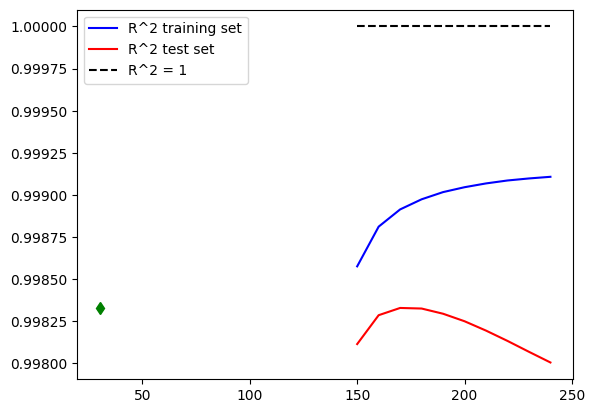

In [ ]:
# training the model many times, while changing the number of epocs being considered

best_model_r2 = -100
r_2_train = []
r_2_test  = []
n_ep = np.arange(150,250,10)
for n_epoch in n_ep:
  model.compile(loss=keras.losses.MeanSquaredError(),optimizer=keras.optimizers.RMSprop())
  nn  = model.fit(x_train, u_train, batch_size=100, epochs=n_epoch, validation_split=0.2, verbose=0)
  r_2_train.append(sklearn.metrics.r2_score(u_train,model.predict(x_train)))
  r_2_test.append(sklearn.metrics.r2_score(u_test,model.predict(x_test)))
  if (max(r_2_test) > best_model_r2):
    best_model_r2 = max(r_2_test)
    best_model_u = model

a = max(r_2_test)
b = r_2_test.index(a)*10 + 10
c = r_2_train[r_2_test.index(a)]

plt.plot(n_ep, r_2_train,'b-', n_ep, r_2_test, 'r-', n_ep, np.ones(n_ep.shape), 'k--', b, a, 'gd')
plt.legend(['R^2 training set', 'R^2 test set', 'R^2 = 1'])

print("Maximum valuation's   R^2:      %6f" %a)
print("Associated training's R^2:      %6f" %c)
print("Number of epochs:               %d"  %b)

# Predicting with the models

The models are now ready to compute the approximated Value Function of a thick grid of points in the 40-dim interval [-3,3]; this can be uploaded from grid.m

In [ ]:
uploaded_ = files.upload()

Saving grid.csv to grid (4).csv


## Approximation via $V_{\theta}$

In [ ]:
grid = pd.read_csv(io.BytesIO(uploaded_['grid.csv']), header=None)
x_grid = tf.constant(grid.values,  dtype = tf.float32, shape=grid.shape)
grid_dataset = tf.data.Dataset.from_tensor_slices(x_grid).batch(grid.shape[0])
V_grid  = []
dV_grid = []
t = time.time()

for step, x_ in enumerate(grid_dataset):
  grid_variable   = tf.Variable(x_)
  with tf.GradientTape() as tape:
    tape.watch(grid_variable)
    pred_V = best_model_V(grid_variable)
    pred_dV = tape.gradient(pred_V, grid_variable)
  V_grid  = pd.DataFrame(pred_V.numpy(),columns = ['V'])
  dV_grid = pd.DataFrame(pred_dV.numpy())

print("Elapsed time is %f seconds." %(time.time() - t))

predicted = pd.concat([V_grid,dV_grid],axis=1)

predicted.to_csv('predicted.csv')


Elapsed time is 0.377714 seconds.


## Approximation via $u_{\theta}$

In [ ]:
grid = pd.read_csv(io.BytesIO(uploaded_['grid.csv']), header=None)
t = time.time()
u_grid = best_model_u.predict(grid)
print("Elapsed time is %f seconds." %(time.time() - t))

pd.DataFrame(u_grid).to_csv('predicted_u.csv')

Elapsed time is 0.243091 seconds.


## Integration and approximated trajectory (Euler method)

Now we consider a trajectory starting with intial state that is a vector of equally spaced entries which follows the dynamics
$$\begin{cases}
\frac{d}{dt}y_i(t) = v_i(t)\\
\frac{d}{dt}v_i(t) = \frac{1}{N_a} \sum_{j = 1}^{N_a} \frac{v_j(t) - v_i(t)}{1 + ||y_i(t) - y_j(t)||^2} + u_i(t)\\
\end{cases}$$
where we consider $u(t) = u(x(t))$, the control resulting from the Neural Network's approximation.

Thus, to evaluate the ODE, we need only the current state $x(t)$ which now becomes the input for the NN trained for $u(x)$.

In [ ]:
def P(a,b):
  return 1/(1 + (a - b)**2)

def semilinearization(y):
  N = int((np.shape(y)[1]/2))
  A_n = np.zeros((N,N))
  for i in range(N):
    P_ii = 0
    for j in range(N):
      if i != j:
        P_ii = P_ii + P(y[0,i],y[0,j])
        A_n[i,j] = P(y[0,i],y[0,j]);
    A_n[i,i] = - P_ii;
  A = np.block([[np.zeros((N, N)), np.identity(N)],
                [np.zeros((N, N)), (1/N)*A_n     ]])
  return A


1/1 [==============================] - 0s 65ms/step
Total cost is 0.250438


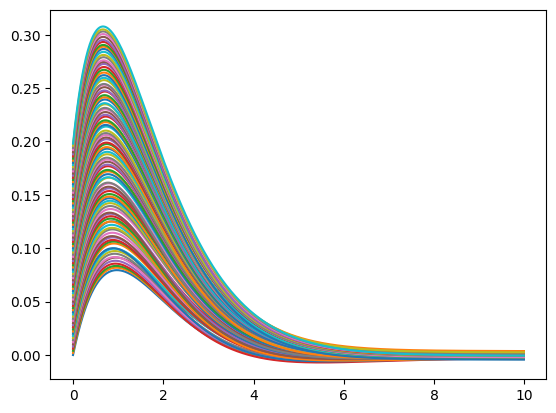

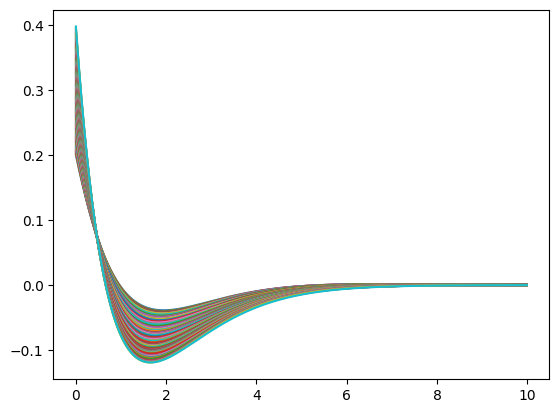

In [ ]:
state   = []
control = []
t_star = 10
m = 1000
k = t_star/m
init_state = np.array(np.arange(0,0.4,0.4/(2*Na)).tolist(),ndmin=2)
state.append(init_state) #initial condition
init_cotrol = best_model_u.predict(init_state) #initial control
control.append(init_cotrol)
cost=sum(np.square(init_state).T)+sum(np.square(init_cotrol).T)

for n in range (m-1):
  A = semilinearization(state[n])
  B = np.zeros((2*Na, 1))
  B[Na:,] = control[n].T
  next_state = np.add(state[n].T, k*(np.add(np.dot(A,state[n].T),B)))
  next_control = best_model_u.predict(next_state.T,verbose=0)
  state.append(next_state.T)
  control.append(next_control)
  cost=cost+sum(np.square(next_state))+sum(np.square(next_control).T)



cost=cost*k/Na
print("Total cost is %f" %cost)

position = [i[:,0:Na] for i in state]
#print("Elapsed time is %f seconds." %(time.time() - t))
for j in range(Na):
  i_th = [i[0,j] for i in position]
  plt.plot(np.arange(0,t_star,k),i_th)
plt.show()

velocities = [i[:,Na:] for i in state]
for j in range(Na):
  i_th = [i[0,j] for i in velocities]
  plt.plot(np.arange(0,t_star,k),i_th)
plt.show()


In [ ]:
for l in range(1, len(best_model_u.layers)):
  layer = best_model_u.layers[l].get_weights()
  np.savetxt('u_weights' + str(l) + '.csv', layer[0], fmt='%s', delimiter=',')
  np.savetxt('u_bias' + str(l) + '.csv', layer[1], fmt='%s', delimiter=',')

# Nuova sezione

In [ ]:
R = np.diag(np.diag(0.01*np.ones((Na,Na))))
B = np.block([[np.zeros((Na, Na))],[np.identity(Na)]])
quasiK = np.dot(-1*(np.linalg.inv(R)),B.T)/2

def u_dV(model,state,temp):
  with tf.GradientTape() as tape:
    tape.watch(state)
    pred_V = model(state)
    pred_dV = tape.gradient(pred_V, state)
  return np.dot(temp,pred_dV.numpy().T)

In [ ]:
state   = []
control = []
t_star = 10
m = 1000
k = t_star/m

init_state = np.ones((1,2*Na))
state.append(init_state) #initial condition
init_cotrol = u_dV(best_model_V,tf.Variable(init_state),quasiK) #initial control
control.append(init_cotrol)

for n in range (m-1):
  A = semilinearization(state[n])
  B = np.zeros((2*Na, 1))
  B[Na:,] = control[n]
  next_state = np.add(state[n].T, k*(np.add(np.dot(A,state[n].T),B)))
  next_control = u_dV(best_model_V,tf.Variable(next_state.T),quasiK)
  state.append(next_state.T)
  control.append(next_control)

position = [i[:,0:Na] for i in state]

for j in range(Na):
  i_th = [i[0,j] for i in position]
  plt.plot(np.arange(0,t_star,k),i_th)
plt.show()


velocities = [i[:,Na:] for i in state]
for j in range(Na):
  i_th = [i[0,j] for i in velocities]
  plt.plot(np.arange(0,t_star,k),i_th)
plt.show()

In [ ]:
control_V = np.zeros((m,Na))
for n in range (m):
  control_V[n][:] = control[n].T
pd.DataFrame(control_V).to_csv('control_V.csv')